In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import random
import matplotlib.pyplot as plt
import math
import glob
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from data_processing import get_data, get_sources_targets_short, get_source_target, get_speed_short, get_with_speed

In [2]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_size = 2,
                 embedding_size = 128,  # this "embedding" is not the real "embedding", it is just a y = Ax linear transformation
                 hidden_size = 256,
                 n_layers = 4,
                 bidirectional = False,
                 dropout = 0.5):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout, bidirectional = bidirectional)
               

    def forward(self, x, hidden):
        # embedded: [sequence len, batch size, embedding size]  #15, 20, 128
        embedded = self.dropout(F.relu(self.linear(x)))
        encoder_outputs, hidden = self.rnn(embedded, hidden)
        return encoder_outputs, hidden  #15, 20, 256 (4, 20, 256)*2
    
    def init_hidden(self):
        return (torch.zeros((1 + int(self.bidirectional))*self.n_layers, BATCH_SIZE, self.hidden_size),
                torch.zeros((1 + int(self.bidirectional))*self.n_layers, BATCH_SIZE, self.hidden_size))

In [3]:
class AttentionDecoder(nn.Module):
    def __init__(self,
                 output_size = 2, 
                 input_size = 2, 
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Linear(input_size, embedding_size)
        self.attn = nn.Linear(hidden_size*2, 1)
        self.rnn = nn.LSTM(embedding_size + hidden_size, hidden_size,  n_layers, dropout = dropout)
        self.linear_output = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    
    def init_hidden(self):
        return (torch.zeros(self.n_layers, BATCH_SIZE, self.hidden_size),
                torch.zeros(self.n_layers, BATCH_SIZE, self.hidden_size))
   
    def forward(self, input, hidden, all_outputs): #[20, 4], [4,20, 256]*2, [11,15, 20, 256] 

        input = input.unsqueeze(0)  #[20, 2]=> unsqueeze =[1, 20, 4]
        embedded = self.dropout(F.relu(self.embedding(input))) #[1, 20, 4]=> embed =[1, 20, 128]
        
        attn_applied = (hidden[0][0]*0).unsqueeze(0).expand(all_outputs.size(0),-1, -1)  # 11,20, 256
        
        """ find the relationship between the (first decoder) hidden state and each encoder_output, 
        method: concat hidden[0] and each encoder_output in dim =1, then perform attention """
        weights = []
        for j in range(len(all_outputs)): 
            for i in range(len(all_outputs[j])):
                weights.append(self.attn(torch.cat((hidden[0][0],all_outputs[j][i]), dim = 1))) 
                # hidden[0] = [4, 20, 256] hidden[0][0] = [20, 256]
                # encoder_outputs = [15, 20, 256] encoder_ouputs[i] = [20, 256]
                # cat(dim 1) = [20, 512] => att =[20]=> for loop = list of 15*11 each item size 20]

        #concat weights in dim = 1,(change list to tensor) and softmax the weight in dim 1
        normalized_weights = F.softmax(torch.cat(weights, 1), 1) #20, 15*11
        
        temp = normalized_weights.view(-1, all_outputs.size(0), all_outputs.size(1)) # 20, 11, 15
        
        # bmm : batch*n*m X batch*m*p = batch*n*p, therefore, unsqueeze in dim = 1 (n = 1)
       
        for j in range(len(all_outputs)):
            
            attn_applied[j] = torch.bmm(temp[:, j, :].unsqueeze(1),all_outputs[j].permute(1, 0, 2)).squeeze(1) 
            #[20,1,15]X[20,15,256] = [20, 1, 256]
        
        final_attn_applied = attn_applied.sum(0) #20, 256
        
        input_lstm = torch.cat((final_attn_applied, embedded[0]), dim = 1)
        # embedded = [1, 20, 128]=> layer 0 = [20, 128] concat = [20, 256+128]
        
        output, hidden = self.rnn(input_lstm.unsqueeze(0), hidden)
        
        final_output = self.linear_output(output.squeeze(0))
        
        return final_output, hidden, normalized_weights
        

In [4]:
class Attn_Enc_Dec(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, target_ordinal, num_target, teacher_forcing_ratio = 0.5):
        """
        x = [batch, seq, feature size=11,  4] 20,15, 11, 4
        y = [batch, seq, feature size= 1, 4]   20, 15, 5, 4
        
        """
        x = x.permute(2, 1, 0, 3) # 11, 15, 20,  4
        y = y.permute(2, 1, 0, 3) # 5,15, 20,  4
        batch_size = x.shape[2] #20
        target_len = y.shape[1] #15
        
        total_encoder_outputs = (x.repeat(1, 1, 1, int(self.encoder.hidden_size/self.encoder.input_size)).clone())*0 
                                                    #11, 15, 20, 256
        neighbor_hidden = []
        decoder_hidden =self.decoder.init_hidden
        for i in range(len(x)): 
            total_encoder_outputs[i], hidden = self.encoder(x[i], encoder.init_hidden())
            neighbor_hidden.append(hidden)
            if (i == target_ordinal):
                decoder_hidden=hidden
       
        
        outputs = torch.zeros(y.shape).clone().to(self.device) #[5, 15, 20, 4]
        
        
        for j in range(num_target):   
            decoder_input = x[target_ordinal+j, -1,:, :]   #[20, 4]

            for i in range(target_len):
                output, hidden, normalized_weights = self.decoder(decoder_input, decoder_hidden, total_encoder_outputs)     
                outputs[j][i] = output #1, 15, 20, 4
                teacher_forcing = random.random() < teacher_forcing_ratio

                    # output is the same shape as input, [batch_size, feature size]
                    # so we can use output directly as input or use true lable depending on
                    # teacher_forcing is true or not
                decoder_input = y[j][i] if teacher_forcing else output
                
        outputs = outputs.permute(2, 1, 0, 3)
        
        return outputs


In [5]:
# produce dataset
class MyDataset(Dataset):
    def __init__(self,data):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        super().__init__()
        self.data = data
        

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        
        return self.data[index]
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.data)



In [6]:
path = './data'
#path = 'D:/data'
df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
game_data, flag_index = get_data(df)
print(game_data[0], flag_index[:5])

[53.11965 27.65268] [    0  5621 11154 12562 13750]


In [7]:
source_ordinal = 0
num_source = 11
target_ordinal = 1
num_target = 3
sources, targets = get_sources_targets_short(game_data, flag_index, 15)
s_speeds, t_speeds = get_speed_short(game_data, flag_index, 15)
# source, target = get_source_target(sources, targets, source_ordinal,num_source,target_ordinal,num_target)
source, target =get_with_speed(sources,s_speeds, source_ordinal,num_source,targets, t_speeds, target_ordinal,num_target )


In [8]:
print(len(source), source[0][0].shape)

2394 torch.Size([11, 4])


In [9]:
BATCH_SIZE = 20
total = []
for i in range(len(source)):
    temp = (source[i], target[i])
    total.append(temp)
example = []
for i in range(BATCH_SIZE):
    temp = (source[i], target[i])
    example.append(temp)

In [10]:
total_data = MyDataset(total)
ex_data =MyDataset(example)
train_size = int(len(total_data) * 0.7)
val_size = int(len(total_data)*0.2)
test_size = len(total_data) - train_size - val_size
train_data,val_data, test_data =random_split(total_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
ex_loader = DataLoader(ex_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)


In [11]:
print(iter(train_loader).__next__()[0].shape,iter(train_loader).__next__()[1].shape )
print(iter(ex_loader).__next__()[0].shape,iter(ex_loader).__next__()[1].shape )

torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])
torch.Size([20, 15, 11, 4]) torch.Size([20, 15, 3, 4])


In [12]:
INPUT_DIM = 4
OUTPUT_DIM = 4
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 4
ENC_DROPOUT = 0
DEC_DROPOUT = 0
BIDIRECTIONAL = False
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, BIDIRECTIONAL, ENC_DROPOUT)      
decoder = AttentionDecoder(OUTPUT_DIM, INPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Attn_Enc_Dec(encoder, decoder, dev).to(dev)

In [13]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        # put data into GPU
        x = x.to(dev)
        y = y.to(dev)
        
        # zero all param gradients
        optimizer.zero_grad()
        
        # run attetion_encoding to get predictions
        y_pred = model(x, y, target_ordinal, num_target, 0.5)
        
        # get loss and compute model trainable params gradients though backpropagation
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # add batch loss, since loss is single item tensor
        # we can get its value by loss.item()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(dev)
            y = y.to(dev)
            
            # turn off teacher forcing
            y_pred = model(x, y, target_ordinal, num_target, teacher_forcing_ratio = 0)
            
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

N_EPOCHES = 20
best_val_loss = float('inf')
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [14]:
# load previous best model params if exists
model_dir = "saved_models/attention"
saved_model_path = model_dir + "/best_attention_11_3_speed.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")



successfully load previous best model parameters


In [15]:
%load_ext tensorboard
writer = SummaryWriter()

In [16]:
for epoch in range(N_EPOCHES):
    
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    end_time = time.time()
    secs = end_time - start_time
    
    print(F'Epoch: {epoch+1:02} | Time:  {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val Loss: {val_loss:.3f}')
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss,epoch)
   
   
   

    if val_loss < best_val_loss:
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
writer.close()

Epoch: 01 | Time:  1205.3216474056244s
	Train Loss: 75.597
	 Val Loss: 78.040
Epoch: 02 | Time:  1154.0935022830963s
	Train Loss: 69.480
	 Val Loss: 76.112
Epoch: 03 | Time:  1100.226919412613s
	Train Loss: 94.934
	 Val Loss: 117.411
Epoch: 04 | Time:  1099.100618839264s
	Train Loss: 90.157
	 Val Loss: 82.658
Epoch: 05 | Time:  1100.6126687526703s
	Train Loss: 80.523
	 Val Loss: 104.411
Epoch: 06 | Time:  1097.240463733673s
	Train Loss: 90.122
	 Val Loss: 130.384
Epoch: 07 | Time:  1096.4456350803375s
	Train Loss: 74.285
	 Val Loss: 99.015
Epoch: 08 | Time:  1096.9986896514893s
	Train Loss: 78.710
	 Val Loss: 101.105
Epoch: 09 | Time:  1096.7814173698425s
	Train Loss: 75.316
	 Val Loss: 89.810
Epoch: 10 | Time:  1091.5130732059479s
	Train Loss: 77.263
	 Val Loss: 78.244
Epoch: 11 | Time:  1093.5724544525146s
	Train Loss: 68.652
	 Val Loss: 97.933
Epoch: 12 | Time:  1096.9302244186401s
	Train Loss: 72.017
	 Val Loss: 87.763
Epoch: 13 | Time:  1094.8687493801117s
	Train Loss: 71.796
	 Va

In [17]:
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f}')
#  | Test PPL: {math.exp(round(test_loss, 3)):7.3f} |')

| Test Loss: 62.340


<Figure size 432x288 with 0 Axes>

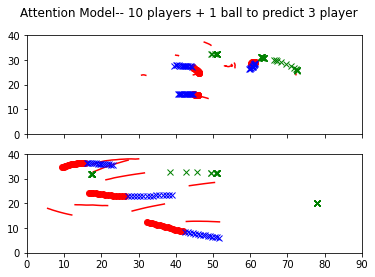

In [18]:
scenes = 2
plt.clf()
fig, axs = plt.subplots(scenes,sharex=True, sharey=True )
plt.axis([0, 90, 0, 40])
fig.suptitle('Attention Model-- 10 players + 1 ball to predict 3 player')
p, q = iter(ex_loader).__next__()  # p [20, 15, 11, 4] q [20, 15, 3, 4]
r = model(p, q, target_ordinal, num_target).detach()  #r [20, 15, 3, 4]
p_= p.permute(0, 2, 1, 3) #20, 11, 15, 4
q_= q.permute(0, 2, 1, 3) 
r_= r.permute(0, 2, 1, 3)
for j in range(scenes):
    for i in range(len(p_[j])):
        if (i >= target_ordinal and i < target_ordinal + num_target):
            axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], 'ro', linewidth=0.5, label = "source")
          
        axs[j].plot(p_[j][i][:, 0], p_[j][i][:, 1], color = "red", label ="ref", )
    for i in range(len(q_[j])):
        axs[j].plot(q_[j][i][:, 0], q_[j][i][:, 1], "bx", linewidth = 0.2, label = "target")
        axs[j].plot(r_[j][i][:, 0], r_[j][i][:, 1], "gx", linewidth = 0.2, label = "predict")

plt.show()

In [19]:
# !tensorboard --logdir=runs

In [ ]:
s_ = q_